# 1) Baixar dataset no Kaggle

-------------

In [4]:
!pip install -q kaggle #download biblioteca Kaggle para baixar dataset
!kaggle datasets download -d hojjatk/mnist-dataset #gera arquivo Zip


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#download': Expected package name at the start of dependency specifier
    #download
    ^
usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config,auth} ...
kaggle: error: unrecognized arguments: arquivo Zip


In [5]:
import zipfile
import os

zip_path = "mnist-dataset.zip" #Zip baixado acima 
extract_path = "mnist_dataset"
os.makedirs(extract_path, exist_ok=True) #extrai dataset para pasta local
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset MNIST baixado e extraído com sucesso")


Dataset MNIST baixado e extraído com sucesso


# 2) Carregar arquivos IDX binários do MNIST

---------------

In [6]:
import numpy as np
import struct
import os

def read_idx_images(filename):
    """Lê arquivo IDX3-UBYTE de imagens MNIST"""
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(filename):
    """Lê arquivo IDX1-UBYTE de labels MNIST"""
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

base_path = "mnist_dataset"# Caminho base da pasta extraída

train_images = read_idx_images(os.path.join(base_path, "train-images.idx3-ubyte"))# Leitura dos arquivos de treino
train_labels = read_idx_labels(os.path.join(base_path, "train-labels.idx1-ubyte")) #Leitura labels de treino
test_images = read_idx_images(os.path.join(base_path, "t10k-images.idx3-ubyte")) #leitura dos arquivos de teste
test_labels = read_idx_labels(os.path.join(base_path, "t10k-labels.idx1-ubyte")) #leitura das labels de teste

print(f"Imagens de treino: {train_images.shape}")
print(f"Labels de treino: {train_labels.shape}")
print(f"Imagens de teste: {test_images.shape}")
print(f"Labels de teste: {test_labels.shape}")

all_images = np.concatenate([train_images, test_images], axis=0) #Recombina teste+treino para fazer uma propria separação 
all_labels = np.concatenate([train_labels, test_labels], axis=0) #recombina labels

print(f"\n Total de dados: {all_images.shape[0]} imagens")


Imagens de treino: (60000, 28, 28)
Labels de treino: (60000,)
Imagens de teste: (10000, 28, 28)
Labels de teste: (10000,)

 Total de dados: 70000 imagens


# 3) Dividir em 70% treino, 15% validação, 15% teste

----

In [11]:
from sklearn.model_selection import train_test_split

# Primeira divisão: 70% treino + 30% restante
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, 
    test_size=0.30, 
    random_state=42, 
    stratify=all_labels
)

# Segunda divisão: 15% validação + 15% teste (50% de 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42, 
    stratify=y_temp
)

print(f"Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(all_images)*100:.1f}%)")
print(f"Validação: {X_val.shape[0]} amostras ({X_val.shape[0]/len(all_images)*100:.1f}%)")
print(f"Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(all_images)*100:.1f}%)")

# Normalização (0-255 → 0.0-1.0) e adicionar canal
X_train = (X_train.astype(np.float32) / 255.0)[..., None]
X_val = (X_val.astype(np.float32) / 255.0)[..., None]
X_test = (X_test.astype(np.float32) / 255.0)[..., None]

print("\n Dados normalizados e formatados!")


Treino: 49000 amostras (70.0%)
Validação: 10500 amostras (15.0%)
Teste: 10500 amostras (15.0%)

 Dados normalizados e formatados!


# 4) Salvar 15% de teste em arquivo PKL 

---------------

- A ideia é salvar esses arquivos de teste para serem usados posteriormente para uso com o modelo ja funcional no pico

In [12]:
import pickle

# Salvar dados de teste em arquivo pickle
test_data = {
    'X_test': X_test,
    'y_test': y_test
}

with open('mnist_test_15percent.pkl', 'wb') as f:
    pickle.dump(test_data, f)

# Informações do arquivo
import os
file_size = os.path.getsize('mnist_test_15percent.pkl') / (1024 * 1024)  # MB

print(f"Conjunto de teste salvo!")
print(f"Amostras: {X_test.shape[0]}")
print(f"Shape: {X_test.shape}")
print(f"Arquivo: mnist_test_15percent.pkl ({file_size:.2f} MB)")


Conjunto de teste salvo!
Amostras: 10500
Shape: (10500, 28, 28, 1)
Arquivo: mnist_test_15percent.pkl (31.41 MB)


# 5. Visualizar amostras do dataset

-------------

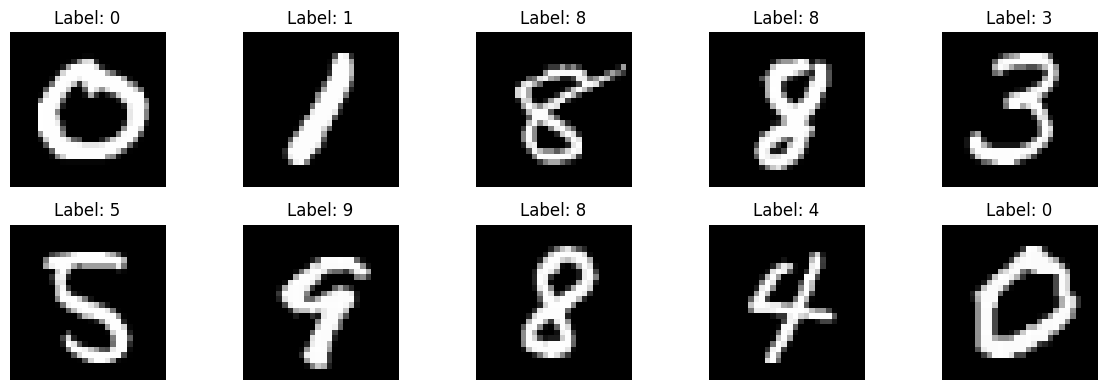

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(10): # para as 10 primeiras imagens
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray') #mostra as 10 primeiras imagens
    plt.title(f"Label: {y_train[i]}")  #mostra a label
    plt.axis('off')
plt.tight_layout()
plt.show()



# 6) Definir CNN leve para TinyML (compatível com RP2040)

-------------------

- devemos baixar a blioteca tensorflow para fazer os treinamentos conforme a arquitetura a ser definida

In [15]:
!pip install tensorflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.Conv2D(8, 3, strides=2, padding="same", activation="relu"),# Conv1: 8 filtros 3x3, stride=2 (28x28 → 14x14)
    tf.keras.layers.Conv2D(16, 3, strides=2, padding="same", activation="relu"),    # Conv2: 16 filtros 3x3, stride=2 (14x14 → 7x7)
    tf.keras.layers.GlobalAveragePooling2D(),    # GlobalAveragePooling reduz parâmetros (vira MEAN no TFLM)
    tf.keras.layers.Dense(10, activation="softmax") #Camada Dense final: 10 classes (Labels de 0 a 10)
])

# Compilar o modelo
model.compile(
    optimizer="adam", #usa otimizador adam
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,418 (5.54 KB)

 Trainable params: 1,418 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

# 7) Treinamento do modelo

---------

In [18]:
history = model.fit( 
    X_train, y_train, #treina apartir dos dados de treino e target de treino
    validation_data=(X_val, y_val), #validação
    epochs=150,
    batch_size=128, #define quantas amostras o modelo processa de uma vez antes de atualizar os pesos.
    verbose=1 #mostra barra de progrresso
)

print("\n Treinamento concluído!")


Epoch 1/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2250 - loss: 2.1230 - val_accuracy: 0.3602 - val_loss: 1.8323
Epoch 2/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4092 - loss: 1.6677 - val_accuracy: 0.4495 - val_loss: 1.5546
Epoch 3/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4841 - loss: 1.4553 - val_accuracy: 0.5123 - val_loss: 1.3921
Epoch 4/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5370 - loss: 1.3220 - val_accuracy: 0.5527 - val_loss: 1.2845
Epoch 5/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5775 - loss: 1.2276 - val_accuracy: 0.5962 - val_loss: 1.2028
Epoch 6/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6053 - loss: 1.1573 - val_accuracy: 0.6109 - val_loss: 1.1417
Epoch 7/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6260 - loss: 1.1030 - val_accuracy: 0.6381 - val_loss: 1.0913
Epoch 8/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6410 - loss: 1.0595 - val_accu

# 8) Avaliar desempenho - Acurácia

-----------

Acurácia no conjunto de TESTE (15%): 88.82%
Loss no conjunto de TESTE: 0.3702

Acurácia final TREINO (70%): 89.06%
Acurácia final VALIDAÇÃO (15%): 88.38%


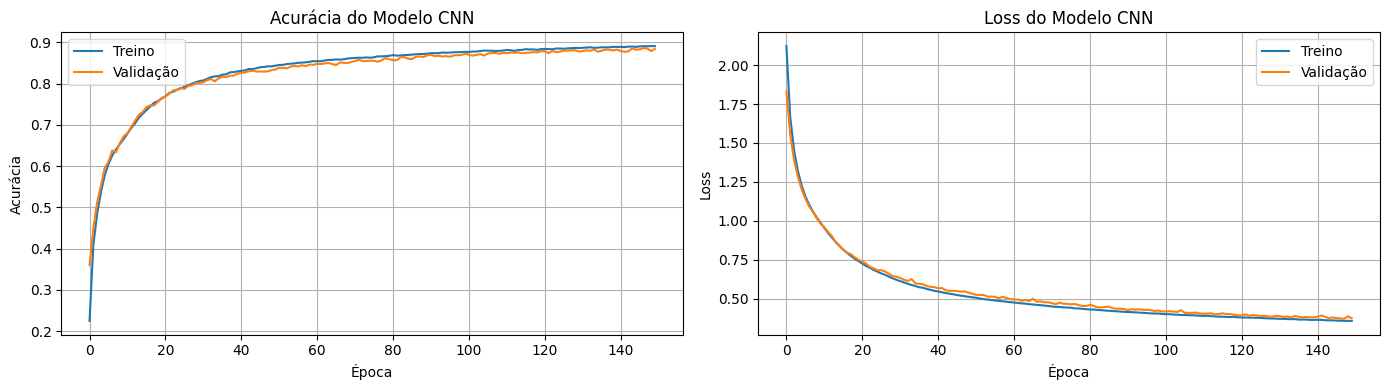

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)#Calcula acuracia para o conjuto de teste separado
print(f"Acurácia no conjunto de TESTE (15%): {test_acc*100:.2f}%")
print(f"Loss no conjunto de TESTE: {test_loss:.4f}")

final_train_acc = history.history['accuracy'][-1] #acuracia de treino
final_val_acc = history.history['val_accuracy'][-1] #acuracia de validação
print(f"\nAcurácia final TREINO (70%): {final_train_acc*100:.2f}%")
print(f"Acurácia final VALIDAÇÃO (15%): {final_val_acc*100:.2f}%")

plt.figure(figsize=(14,4))# Gráficos de acurácia e loss

#grafico treino
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia do Modelo CNN')
plt.legend()
plt.grid(True)

#grafico validação
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss do Modelo CNN')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 9) Matriz de Confusão

----------

<Figure size 1000x800 with 0 Axes>

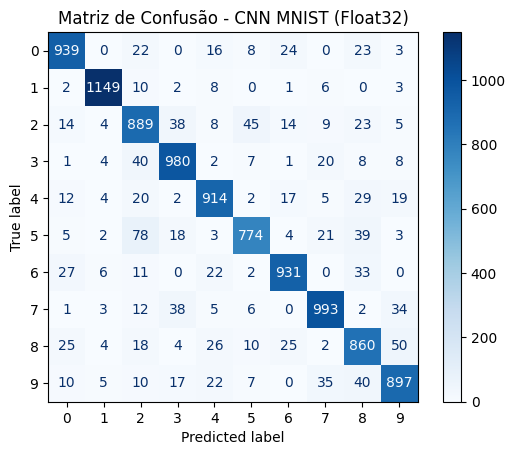

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)# Predições no conjunto de teste
cm = confusion_matrix(y_test, y_pred)# Calcular matriz de confusão nos dados de teste (15% separado)
#dados nao apresentados no treinamento

# Plota
plt.figure(figsize=(10,8))
disp = ConfusionMatrixDisplay(cm, display_labels=range(10))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusão - CNN MNIST (Float32)")
plt.show()

# 10) Relatório de Classificação (Precision, Recall, F1-Score)

--------

In [21]:
from sklearn.metrics import classification_report

print("RELATÓRIO DE CLASSIFICAÇÃO")
report = classification_report(y_test, y_pred, digits=4) #armazena o relaotrio com precisão, recall, f1 score e acuracia
#usa nos dados de teste
print(report)


RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

           0     0.9064    0.9072    0.9068      1035
           1     0.9729    0.9729    0.9729      1181
           2     0.8009    0.8475    0.8235      1049
           3     0.8917    0.9150    0.9032      1071
           4     0.8908    0.8926    0.8917      1024
           5     0.8990    0.8173    0.8562       947
           6     0.9154    0.9021    0.9087      1032
           7     0.9102    0.9077    0.9089      1094
           8     0.8136    0.8398    0.8265      1024
           9     0.8777    0.8600    0.8688      1043

    accuracy                         0.8882     10500
   macro avg     0.8879    0.8862    0.8867     10500
weighted avg     0.8890    0.8882    0.8883     10500



# 11) Converter para TFLite INT8 (para RP2040)


-------------

In [22]:
# Dataset representativo para calibração
def representative_dataset():
    for i in range(200):
        yield [X_train[i:i+1]]

# Converter para TFLite INT8 (modelos que usaramos no pico)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_int8_model = converter.convert() #aplica conversao

# Salvar arquivo .tflite
with open("mnist_cnn_int8.tflite", "wb") as f:
    f.write(tflite_int8_model)
print(f"Modelo TFLite INT8 gerado!")
print(f"Tamanho: {len(tflite_int8_model)} bytes ({len(tflite_int8_model)/1024:.2f} KB)")


INFO:tensorflow:Assets written to: C:\Users\Jonas\AppData\Local\Temp\tmps6r0n2kz\assets


INFO:tensorflow:Assets written to: C:\Users\Jonas\AppData\Local\Temp\tmps6r0n2kz\assets


Saved artifact at 'C:\Users\Jonas\AppData\Local\Temp\tmps6r0n2kz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2267404963472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2267404968272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2267404967888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2267404968656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2267404967120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2267404969232: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\Jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Modelo TFLite INT8 gerado!
Tamanho: 5200 bytes (5.08 KB)


# 12) Gerar arquivo .h para embarcar no RP2040


---------------

In [23]:
import binascii
with open("mnist_cnn_int8.tflite", "rb") as f:# Ler modelo TFLite
    tflite_data = f.read()

hexstr = binascii.hexlify(tflite_data).decode("ascii")

# Gerar arquivo .h
with open("mnist_cnn_int8_model.h", "w") as f:
    f.write('#pragma once\n')
    f.write('#include <stdint.h>\n\n')
    f.write('alignas(16) const unsigned char mnist_cnn_int8_model[] = {\n')
    
    # Escrever 12 bytes por linha
    for i in range(0, len(hexstr), 24):
        chunk = hexstr[i:i+24]
        bytes_list = [f"0x{chunk[j:j+2]}" for j in range(0, len(chunk), 2)]
        f.write("  " + ", ".join(bytes_list) + ",\n")
    
    f.write("};\n")
    f.write(f"const unsigned int mnist_cnn_int8_model_len = {len(tflite_data)};\n")

print("arquivo mnist_cnn_int8_model.h gerado!")

# Mostrar primeiras linhas
with open("mnist_cnn_int8_model.h", "r") as f:
    lines = f.readlines()
    for line in lines[:15]:
        print(line, end='')


arquivo mnist_cnn_int8_model.h gerado!
#pragma once
#include <stdint.h>

alignas(16) const unsigned char mnist_cnn_int8_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x98, 0x00, 0x00, 0x00, 0xf0, 0x00, 0x00, 0x00, 0x20, 0x08, 0x00, 0x00,
  0x30, 0x08, 0x00, 0x00, 0xbc, 0x13, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00,


# 13) Gerar amostras de teste em .txt para enviar ao RP2040 Via serial

------

In [24]:
# Gerar arquivo com 10 amostras (uma de cada dígito 0-9)
num_samples = 10

with open("mnist_test_samples.txt", "w") as f:
    f.write("# MNIST Test Samples - Formato: Label seguido de 784 pixels (0-255)\n")
    f.write("# Cada linha: label,pixel1,pixel2,...,pixel784\n")
    f.write("# Use estas amostras para testar o RP2040 via Serial/UART\n")
    f.write("#" + "="*70 + "\n\n")
    
    # Encontrar uma amostra de cada dígito
    for digit in range(10):
        idx = np.where(y_test == digit)[0][0]
        img = (X_test[idx] * 255.0).astype(np.uint8).flatten()
        label = int(y_test[idx])
        # Escrever: label,pixel1,pixel2,...,pixel784 -> primeiro numero
        f.write(f"{label}")
        for pixel in img:
            f.write(f",{pixel}")
        f.write("\n")

print(f"Arquivo mnist_test_samples.txt gerado!")
print(f"{num_samples} amostras (dígitos 0-9)")
print(f"Formato: label,pixel1,pixel2,...,pixel784")

Arquivo mnist_test_samples.txt gerado!
10 amostras (dígitos 0-9)
Formato: label,pixel1,pixel2,...,pixel784


# 15) Testar se o .h funciona com amostras do .txt

-------------

c:\Users\Jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


VALIDAÇÃO DO MODELO .h COM AMOSTRAS DO ARQUIVO TXT
✅ Amostra 0: Label=0 | Pred=0 | Conf=22.2%
✅ Amostra 1: Label=1 | Pred=1 | Conf=19.3%
✅ Amostra 2: Label=2 | Pred=2 | Conf=23.0%
✅ Amostra 3: Label=3 | Pred=3 | Conf=23.1%
✅ Amostra 4: Label=4 | Pred=4 | Conf=12.2%
✅ Amostra 5: Label=5 | Pred=5 | Conf=22.4%
✅ Amostra 6: Label=6 | Pred=6 | Conf=22.9%
❌ Amostra 7: Label=7 | Pred=9 | Conf=17.0%
❌ Amostra 8: Label=8 | Pred=2 | Conf=12.7%
✅ Amostra 9: Label=9 | Pred=9 | Conf=19.8%
RESUMO DOS TESTES
Total de amostras:  10
Acertos:            8
Erros:              2
Acurácia:           80.00%


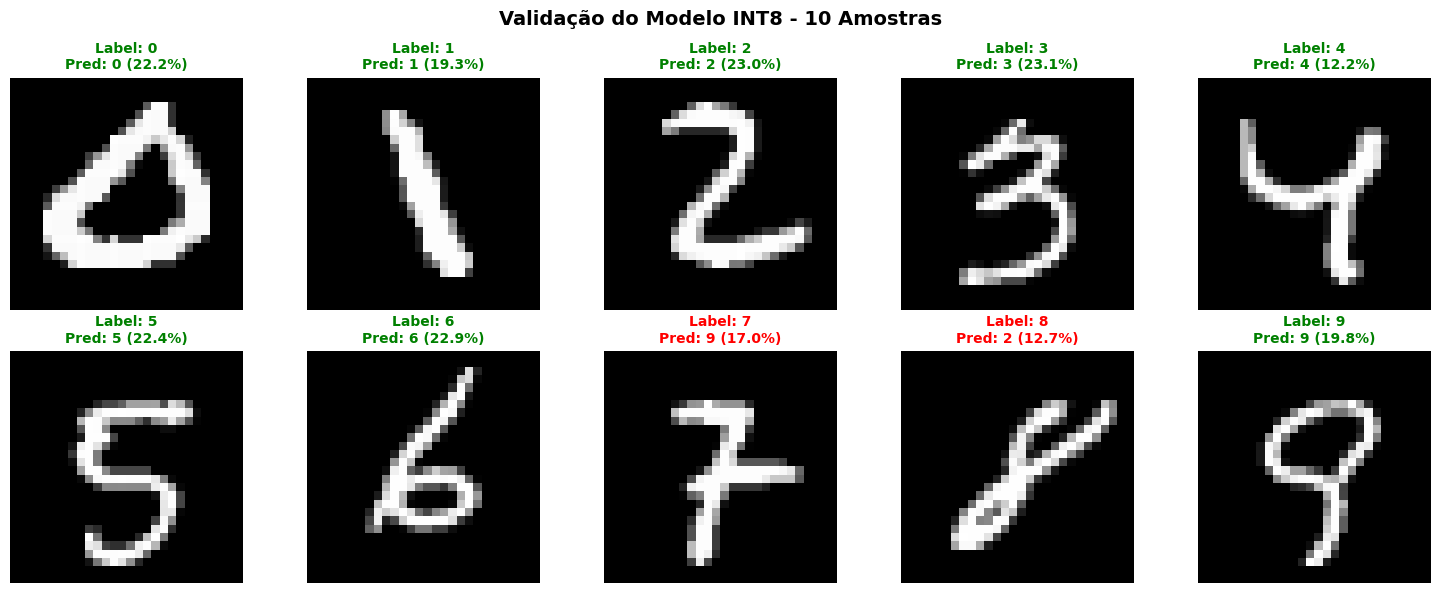

In [26]:

# Ler bytes do arquivo .h
hex_bytes = []
with open("mnist_cnn_int8_model.h") as f: #arquivo do modelo.h
    for line in f:
        if "0x" in line:
            parts = line.strip().split(",")
            for p in parts:
                p = p.strip()
                if p.startswith("0x"):
                    hex_bytes.append(int(p, 16))

tflite_from_h = bytes(hex_bytes)
interpreter = tf.lite.Interpreter(model_content=tflite_from_h) #interpretador tflite
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Parâmetros de quantização
in_scale, in_zp = input_details[0]["quantization"]
out_scale, out_zp = output_details[0]["quantization"]

print("=" * 70)
print("VALIDAÇÃO DO MODELO .h COM AMOSTRAS DO ARQUIVO TXT")
print("=" * 70)

# Ler amostras de teste do arquivo txt
test_samples = []
with open("mnist_test_samples.txt", "r") as f:
    for line in f:
        if not line.startswith("#") and line.strip():
            parts = line.strip().split(",")
            label = int(parts[0])
            pixels = np.array([int(p) for p in parts[1:]], dtype=np.uint8)
            test_samples.append((label, pixels))

# Testar todas as amostras
correct = 0
total = len(test_samples)

results = []
for idx, (true_label, pixels) in enumerate(test_samples):
    # Normalizar e quantizar
    x_normalized = pixels.astype(np.float32) / 255.0
    x_normalized = x_normalized.reshape(1, 28, 28, 1)
    x_q = np.round(x_normalized / in_scale + in_zp).astype(np.int8)
    # Inferência
    interpreter.set_tensor(input_details[0]["index"], x_q)
    interpreter.invoke()
    out = interpreter.get_tensor(output_details[0]["index"])[0]
    # Predição
    pred = np.argmax(out)
    # Calcular probabilidades
    probs_dequant = (out.astype(np.float32) - out_zp) * out_scale
    exp_probs = np.exp(probs_dequant - np.max(probs_dequant))
    probs_normalized = exp_probs / np.sum(exp_probs)
    confidence = probs_normalized[pred] * 100
    
    # Verificar acerto
    is_correct = (pred == true_label)
    if is_correct:
        correct += 1
    
    results.append({
        'label': true_label,
        'pred': pred,
        'confidence': confidence,
        'correct': is_correct,
        'pixels': pixels
    })
    
    # Mostrar resultado individual
    status = "✅" if is_correct else "❌"
    print(f"{status} Amostra {idx}: Label={true_label} | Pred={pred} | Conf={confidence:.1f}%")

# Resumo
print("=" * 70)
print(f"RESUMO DOS TESTES")
print("=" * 70)
print(f"Total de amostras:  {total}")
print(f"Acertos:            {correct}")
print(f"Erros:              {total - correct}")
print(f"Acurácia:           {correct/total*100:.2f}%")
print("=" * 70)

# Visualizar todas as predições
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, (ax, result) in enumerate(zip(axes, results)):
    img = result['pixels'].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    
    color = 'green' if result['correct'] else 'red'
    title = f"Label: {result['label']}\nPred: {result['pred']} ({result['confidence']:.1f}%)"
    ax.set_title(title, fontsize=10, color=color, weight='bold')
    ax.axis('off')

plt.suptitle("Validação do Modelo INT8 - 10 Amostras", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
